### Trigger mechanism for Somalia 

IPC trigger design as endorsed early 2020 (no forecast period- ML1 or ML2 -was specified):   

- The projected national population in Phase 3 and above exceed 20%, AND 
- The national population in Phase 3 is projected to increase by 5 percentage points, OR 
- The projected national population in Phase 4 or above is 2.5%

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.colors as mcolors
import geopandas as gpd
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [2]:
country="Somalia"

In [3]:
# load world-pop-weighted fewsnet data
# note CS_99 denotes missing values
df_fadm=pd.read_csv(f"../Data/FewsNetWorldPop/som_admin1_fewsnet_worldpop.csv",index_col=0)
adm1c="ADMIN1" 
admc="ADMIN1" #"admin1Name"

In [4]:
# extract year and month from date
df_fadm["date"] = pd.to_datetime(df_fadm["date"])
df_fadm["year"] = df_fadm["date"].dt.year
df_fadm["month"] = df_fadm["date"].dt.month

In [5]:
df_fadm

,date,ADMIN1,CS_2,CS_3,CS_4,CS_99,ML1_1,ML1_2,ML1_3,ML1_4,...,ML1_5,ML2_5,pop_CS,pop_Total_CS,pop_ML1,pop_Total_ML1,pop_ML2,pop_Total_ML2,year,month
0,2009-07-01,Awdal,20.72,0.00,0.00,463644.93,0.00,20.72,0.00,0.00,...,0.00,0.00,20.72,463665.65,20.72,463665.65,20.72,463665.65,2009,7
1,2009-07-01,Bakool,0.00,0.00,0.00,483539.54,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,483539.54,0.00,483539.54,0.00,483539.54,2009,7
2,2009-07-01,Banadir,0.00,0.00,0.00,1388087.50,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,1388087.50,0.00,1388087.50,0.00,1388087.50,2009,7
3,2009-07-01,Bari,0.00,0.00,0.00,595480.55,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,595480.55,0.00,595480.55,0.00,595480.55,2009,7
4,2009-07-01,Bay,0.00,0.00,0.00,968685.09,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,968685.09,0.00,968685.09,0.00,968685.09,2009,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
733,2020-10-01,Nugaal,119627.93,144516.70,0.00,nan,0.00,119627.93,144516.70,0.00,...,0.00,0.00,264144.63,264144.63,264144.63,264144.63,264144.63,264144.63,2020,10
734,2020-10-01,Sanaag,21384.41,548290.40,0.00,nan,0.00,21384.41,548290.40,0.00,...,0.00,0.00,569674.81,569674.81,569674.81,569674.81,569674.81,569674.81,2020,10
735,2020-10-01,Sool,55848.40,254617.74,0.00,nan,0.00,55848.40,254617.74,0.00,...,0.00,0.00,310466.14,310466.14,310466.14,310466.14,310466.14,310466.14,2020,10
736,2020-10-01,Togdheer,676748.79,175309.57,0.00,nan,0.00,676748.79,175309.57,0.00,...,0.00,0.00,852058.36,852058.36,852058.36,852058.36,852058.36,852058.36,2020,10


In [6]:
# list column names
df_fadm.columns    

Index(['date', 'ADMIN1', 'CS_2', 'CS_3', 'CS_4', 'CS_99', 'ML1_1', 'ML1_2',
       'ML1_3', 'ML1_4', 'ML1_99', 'ML2_1', 'ML2_2', 'ML2_3', 'ML2_4',
       'ML2_99', 'CS_1', 'CS_5', 'ML1_5', 'ML2_5', 'pop_CS', 'pop_Total_CS',
       'pop_ML1', 'pop_Total_ML1', 'pop_ML2', 'pop_Total_ML2', 'year',
       'month'],
      dtype='object')

### National trigger


In [7]:
# compute national totals
df_ntl = df_fadm.drop(['year', 'month'], axis=1).groupby(by='date', axis=0, as_index = False).sum()
df_ntl.head(10)

,date,CS_2,CS_3,CS_4,CS_99,ML1_1,ML1_2,ML1_3,ML1_4,ML1_99,...,CS_1,CS_5,ML1_5,ML2_5,pop_CS,pop_Total_CS,pop_ML1,pop_Total_ML1,pop_ML2,pop_Total_ML2
0,2009-07-01,20.72,0.00,0.00,11660248.69,0.00,20.72,0.00,0.00,11660248.69,...,0.00,0.00,0.00,0.00,20.72,11660269.41,20.72,11660269.41,20.72,11660269.41
1,2009-10-01,20.72,6801018.54,4859229.98,0.00,0.00,0.00,6801039.26,4859229.98,0.00,...,0.00,0.00,0.00,0.00,11660269.24,11660269.24,11660269.24,11660269.24,11660269.24,11660269.24
2,2010-01-01,3070512.74,4317091.06,4599493.71,0.00,0.00,3070512.74,4317073.50,4599511.25,0.00,...,0.00,0.00,0.00,0.00,11987097.50,11987097.50,11987097.49,11987097.49,11987097.53,11987097.53
3,2010-04-01,3003964.65,4292968.11,4690164.69,0.00,0.00,3003964.65,4292968.11,4690164.69,0.00,...,0.00,0.00,0.00,0.00,11987097.46,11987097.46,11987097.46,11987097.46,11987097.38,11987097.38
4,2010-07-01,6806350.66,2885028.04,2295718.78,0.00,0.00,6806350.66,2885028.04,2295718.78,0.00,...,0.00,0.00,0.00,0.00,11987097.48,11987097.48,11987097.48,11987097.48,11987097.45,11987097.45
5,2010-10-01,6347000.70,1666470.89,3973625.85,0.00,0.00,5368684.06,2920178.37,3698235.06,0.00,...,0.00,0.00,0.00,0.00,11987097.43,11987097.43,11987097.49,11987097.49,11987097.47,11987097.47
6,2011-01-01,6533228.28,1698990.04,4085611.35,0.00,0.00,7552416.13,9043591.61,8039651.62,24635659.35,...,0.00,0.00,0.00,0.00,12317829.68,12317829.68,24635659.35,49271318.71,12317829.68,12317829.68
7,2011-04-01,6470810.96,1761407.36,4085611.35,0.00,0.00,1923555.64,1644031.75,1383822.37,0.00,...,0.00,0.00,7366419.92,0.00,12317829.68,12317829.68,12317829.68,12317829.68,12317829.68,12317829.68
8,2011-07-01,1923555.64,1644031.75,6860911.18,0.00,0.00,1861516.83,3131651.15,4451504.74,0.00,...,0.00,1889331.11,2873156.97,7366419.92,12317829.68,12317829.68,12317829.69,12317829.69,12317829.68,12317829.68
9,2011-10-01,1869213.17,3094879.95,4419001.09,0.00,0.00,7029794.13,4168937.01,1119098.55,0.00,...,0.00,2934735.48,0.00,0.00,12317829.69,12317829.69,12317829.69,12317829.69,12317829.69,12317829.69


In [8]:
def add_percentages(df):
    # calculate percentage of population per period and phase
    for period in ["CS", "ML1", "ML2"]:
        # IPC phases goes up to 5, so define range up to 6
        for i in range(1, 6):
            c = f"{period}_{i}"
            df[f"perc_{c}"] = df[c] / df[f"pop_{period}"] * 100
        # get pop and perc in IPC3+ and IPC2-
        # 3p = IPC phase 3 or higher, 4p = IPC phase 4 or higher
        df[f"{period}_3p"] = df[[f"{period}_{i}" for i in range(3, 6)]].sum(axis=1)
        df[f"perc_{period}_3p"] = df[f"{period}_3p"] / df[f"pop_{period}"] * 100
        df[f"{period}_4p"] = df[[f"{period}_{i}" for i in range(4, 6)]].sum(axis=1)
        df[f"perc_{period}_4p"] = df[f"{period}_4p"] / df[f"pop_{period}"] * 100
    df["perc_inc_ML2_3p"] = df["perc_ML2_3p"] - df["perc_CS_3p"]
    df["perc_inc_ML1_3p"] = df["perc_ML1_3p"] - df["perc_CS_3p"]
    return df

In [9]:
df_ntl=add_percentages(df_ntl)
df_ntl.head()

,date,CS_2,CS_3,CS_4,CS_99,ML1_1,ML1_2,ML1_3,ML1_4,ML1_99,...,perc_ML2_2,perc_ML2_3,perc_ML2_4,perc_ML2_5,ML2_3p,perc_ML2_3p,ML2_4p,perc_ML2_4p,perc_inc_ML2_3p,perc_inc_ML1_3p
0,2009-07-01,20.72,0.00,0.00,11660248.69,0.00,20.72,0.00,0.00,11660248.69,...,100.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,2009-10-01,20.72,6801018.54,4859229.98,0.00,0.00,0.00,6801039.26,4859229.98,0.00,...,0.00,58.33,41.67,0.00,11660269.24,100.00,4859229.98,41.67,0.00,0.00
2,2010-01-01,3070512.74,4317091.06,4599493.71,0.00,0.00,3070512.74,4317073.50,4599511.25,0.00,...,19.95,41.42,38.64,0.00,9596268.72,80.05,4631466.61,38.64,5.67,-0.00
3,2010-04-01,3003964.65,4292968.11,4690164.69,0.00,0.00,3003964.65,4292968.11,4690164.69,0.00,...,25.93,49.87,24.20,0.00,8878537.87,74.07,2900414.07,24.20,-0.87,0.00
4,2010-07-01,6806350.66,2885028.04,2295718.78,0.00,0.00,6806350.66,2885028.04,2295718.78,0.00,...,29.68,47.27,23.05,0.00,8429187.80,70.32,2763467.52,23.05,27.10,0.00


In [10]:
#Trigger definition:
#The projected population in phase 3 and above exceed 20%, AND
#The projected population in phase 3 is projected to increase by a further 5%, OR
#The projected population in phase 4 or above is 2.5%

def get_national_abs_criterion(row, period, phase, threshold):
    """
    Return 1 if percentage of population in row for period in phase "phase" or higher, equals or larger than. 
    Threshold should NOT be a decimal (ie 5 for 5 percent, not .05) 
    """
    # range till 6 cause 5 is max phase
    cols = [f"perc_{period}_{l}" for l in range(phase, 6)]
    if np.isnan(row[f"pop_{period}"]):
        return np.nan
    if round(row[cols].sum()) >= threshold:
        return 1
    else:
        return 0
    
def get_national_increase_criterion(row, period, phase, threshold):
    """
    Return 1 if for row percentage in >="phase" projected at Period minus percentage currently (CS) in >="phase" is expected to be larger than Threshold
    For Global IPC the population analysed in ML2 is sometimes different than in CS. That is why we work directly with percentages and not anymore with (pop period phase+ - pop CS phase+) / pop CS
    Threshold should NOT be a decimal (ie 5 for 5 percent, not .05) 
    """
    # range till 6 cause 5 is max phase
    cols__ml = [f"perc_{period}_{l}" for l in range(phase, 6)]
    cols__cs = [f"perc_CS_{l}" for l in range(phase, 6)]
    if row[["pop_CS", f"pop_{period}"]].isnull().values.any():
        return np.nan
    if row[cols__ml].sum() == 0:
        return 0
    if round(row[cols__ml].sum() - row[cols__cs].sum()) >= threshold:
        return 1
    else:
        return 0    

In [11]:
# apply criteria. Returns 1 if criterion is met.

df_ntl["natl_criterion_ML1_3_20"] = df_ntl.apply(lambda x: get_national_abs_criterion(x,"ML1",3,20),axis=1)
df_ntl["natl_criterion_ML1_3_5in"] = df_ntl.apply(lambda x: get_national_increase_criterion(x,"ML1",3,5),axis=1)
df_ntl["natl_criterion_ML1_4_2half"] = df_ntl.apply(lambda x: get_national_abs_criterion(x,"ML1",4,2.5),axis=1)

df_ntl["natl_criterion_ML2_3_20"] = df_ntl.apply(lambda x: get_national_abs_criterion(x,"ML2",3,20),axis=1)
df_ntl["natl_criterion_ML2_3_5in"] = df_ntl.apply(lambda x: get_national_increase_criterion(x,"ML2",3,5),axis=1)
df_ntl["natl_criterion_ML2_4_2half"] = df_ntl.apply(lambda x: get_national_abs_criterion(x,"ML2",4,2.5),axis=1)


In [12]:
# determine whether national trigger is met

df_ntl['national_trigger_ML1'] =  np.where((df_ntl['natl_criterion_ML1_3_20'] & df_ntl['natl_criterion_ML1_3_5in'] ) | (df_ntl['natl_criterion_ML1_4_2half'] == 1), 1, 0)
df_ntl['national_trigger_ML2'] =  np.where((df_ntl['natl_criterion_ML2_3_20'] & df_ntl['natl_criterion_ML2_3_5in'] ) | (df_ntl['natl_criterion_ML2_4_2half'] == 1), 1, 0)

In [13]:
# extract year / month per row

df_ntl["date"] = pd.to_datetime(df_ntl["date"])
df_ntl["year"] = df_ntl["date"].dt.year
df_ntl["month"] = df_ntl["date"].dt.month

In [14]:
# list years / months during which national trigger would have been met

national_activations_ML1 = df_ntl.loc[(df_ntl["national_trigger_ML1"] == 1)]
national_activations_ML1['period'] = 'ML1'
national_activations_ML1['adm0c'] = country

national_activations_ML2 = df_ntl.loc[(df_ntl["national_trigger_ML2"] == 1)]
national_activations_ML2['period'] = 'ML2'
national_activations_ML2['adm0c'] = country

activation_frames = [national_activations_ML1, national_activations_ML2]
national_activations = pd.concat(activation_frames)

display(national_activations_ML1.round(2).groupby(['year', 'month'], as_index=False)['period','perc_CS_3p','perc_CS_4','perc_ML1_3p','perc_ML1_4'].agg(lambda x: list(x)))
display(national_activations_ML2.round(2).groupby(['year', 'month'], as_index=False)['period','perc_CS_3p','perc_CS_4','perc_ML2_3p','perc_ML2_4'].agg(lambda x: list(x)))


,year,month,period,perc_CS_3p,perc_CS_4,perc_ML1_3p,perc_ML1_4
0,2009,10,[ML1],[100.0],[41.67],[100.0],[41.67]
1,2010,1,[ML1],[74.38],[38.37],[74.38],[38.37]
2,2010,4,[ML1],[74.94],[39.13],[74.94],[39.13]
3,2010,7,[ML1],[43.22],[19.15],[43.22],[19.15]
4,2010,10,[ML1],[47.05],[33.15],[55.21],[30.85]
5,2011,1,[ML1],[46.96],[33.17],[69.34],[32.63]
6,2011,4,[ML1],[47.47],[33.17],[84.38],[11.23]
7,2011,7,[ML1],[84.38],[55.7],[84.89],[36.14]
8,2011,10,[ML1],[84.83],[35.87],[42.93],[9.09]
9,2012,1,[ML1],[33.07],[9.36],[47.3],[4.44]


,year,month,period,perc_CS_3p,perc_CS_4,perc_ML2_3p,perc_ML2_4
0,2009,10,[ML2],[100.0],[41.67],[100.0],[41.67]
1,2010,1,[ML2],[74.38],[38.37],[80.05],[38.64]
2,2010,4,[ML2],[74.94],[39.13],[74.07],[24.2]
3,2010,7,[ML2],[43.22],[19.15],[70.32],[23.05]
4,2010,10,[ML2],[47.05],[33.15],[55.21],[33.86]
5,2011,1,[ML2],[46.96],[33.17],[49.86],[25.09]
6,2011,4,[ML2],[47.47],[33.17],[84.89],[37.42]
7,2011,7,[ML2],[84.38],[55.7],[84.38],[11.23]
8,2011,10,[ML2],[84.83],[35.87],[76.72],[46.47]
9,2012,1,[ML2],[33.07],[9.36],[43.0],[9.36]


In [15]:
# create dictionary of past activations by ML1

dict_natl_activ={}
dict_natl_activ["past_ML1"]={"df": national_activations_ML1,
                  "trig_cols":["CS_3p","ML1_3p","ML1_4"],
                  "desc":"At least 20% of ADMIN1 population in IPC3+ at ML1 AND increase by 5 percentage points in ADMIN1 pop. projected in IPC3+ compared to current state) OR (At least 2.5% of ADMIN1 population projected at IPC4+ by ML1"}

dict_natl_activ["past_ML2"]={"df": national_activations_ML2,
                  "trig_cols":["CS_3p","ML2_3p","ML2_4"],
                  "desc":"At least 20% of ADMIN1 population in IPC3+ at ML2 AND increase by 5 percentage points in ADMIN1 pop. projected in IPC3+ compared to current state) OR (At least 2.5% of ADMIN1 population projected at IPC4+ by ML2"}

dict_natl_activ

{'past_ML1': {'df':          date        CS_2       CS_3       CS_4  CS_99      ML1_1       ML1_2  \
  1  2009-10-01       20.72 6801018.54 4859229.98   0.00       0.00        0.00   
  2  2010-01-01  3070512.74 4317091.06 4599493.71   0.00       0.00  3070512.74   
  3  2010-04-01  3003964.65 4292968.11 4690164.69   0.00       0.00  3003964.65   
  4  2010-07-01  6806350.66 2885028.04 2295718.78   0.00       0.00  6806350.66   
  5  2010-10-01  6347000.70 1666470.89 3973625.85   0.00       0.00  5368684.06   
  6  2011-01-01  6533228.28 1698990.04 4085611.35   0.00       0.00  7552416.13   
  7  2011-04-01  6470810.96 1761407.36 4085611.35   0.00       0.00  1923555.64   
  8  2011-07-01  1923555.64 1644031.75 6860911.18   0.00       0.00  1861516.83   
  9  2011-10-01  1869213.17 3094879.95 4419001.09   0.00       0.00  7029794.13   
  10 2012-01-01  8467858.56 3000069.09 1184734.71   0.00       0.00  6668359.95   
  28 2017-02-01 10390379.09 2528741.96 1593349.73   0.00       0.00  

In [16]:
# function to plot years during which national trigger would have been met (regardless of month or number of activations)

def plot_natl_trig(dict_natl_trigger, adm0c="admin0Name", shape_path="../Data/som_adm_undp_shp/Som_Admbnda_Adm0_UNDP.shp"):
    gdf = gpd.read_file(shape_path)

    count = 1
    f, ax = plt.subplots(figsize=(12,12))
    for d in range(2009,2021):
        ax2 = plt.subplot(4, 4, count)
        gdf.plot(ax=ax2, color='#DDDDDD', edgecolor='#BBBBBB')
        regions = dict_natl_trigger['adm0c'].loc[dict_natl_trigger['year']==d]
        if len(regions) > 0:
            gdf.loc[gdf[adm0c].isin(regions)].plot(ax=ax2, color='red')
        plt.title(f"Past triggers {d}")
        count+=1
        ax2.axis("off")
    plt.show()
    

ML1 projections


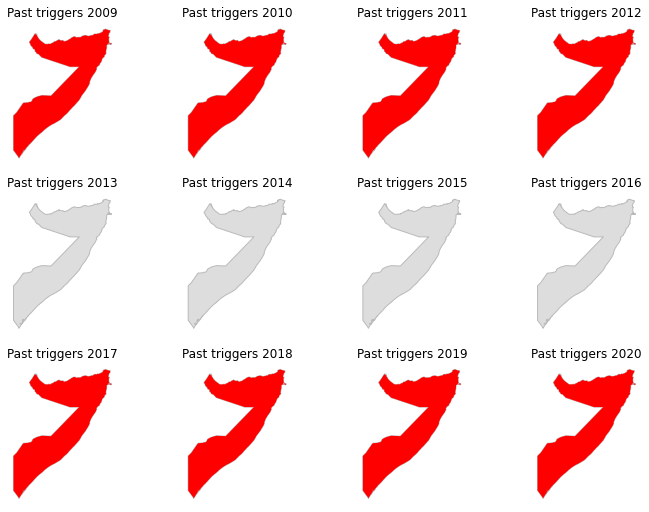

ML2 projections


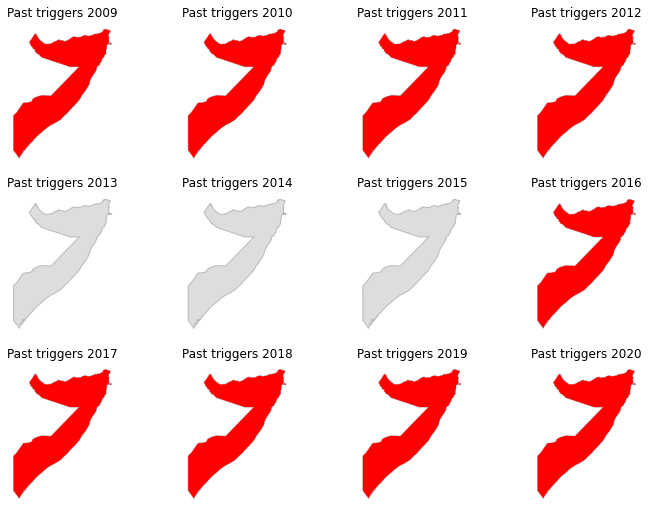

In [17]:
# plot past activations of national trigger
print("ML1 projections")
plot_natl_trig(dict_natl_activ["past_ML1"]["df"])

print("ML2 projections")
plot_natl_trig(dict_natl_activ["past_ML2"]["df"])

In [18]:
# define function to plot percentage of population in IPC3+ or IPC4+

def plot_aff_dates(df_d,df_trig,col,shape_path="../Data/som_adm_undp_shp/Som_Admbnda_Adm0_UNDP.shp",title=None):
    
    num_dates=len(df_trig.date.unique())
    colp_num=2
    rows=num_dates // colp_num
    rows+=num_dates % colp_num
    position = range(1, num_dates + 1)

    gdf = gpd.read_file(shape_path)
    df_geo=gdf[["admin0Name","geometry"]].merge(df_d,left_on="admin0Name",right_on="adm0c",how="left")
    
    colors = len(df_geo[col].unique())
    cmap = 'Blues'
    figsize = (16, 10)
    scheme = "natural_breaks" #'equal_interval' 
    fig = plt.figure(1,figsize=(16,6*rows))
    
    for i,c in enumerate(df_trig.date.unique()):
        ax = fig.add_subplot(rows,colp_num,position[i])
        df_date=df_geo[df_geo.date==c]
        if df_date[col].isnull().values.all():
            print(f"No not-NaN values for {c}")
        elif df_date[col].isnull().values.any():
            df_geo[df_geo.date==c].plot(col, ax=ax,cmap=cmap, figsize=figsize, k = colors,  legend=True,scheme=scheme,missing_kwds={"color": "lightgrey", "edgecolor": "red",
   "hatch": "///",
    "label": "Missing values"})
        else:
            df_geo[df_geo.date==c].plot(col, ax=ax,cmap=cmap, figsize=figsize, k = colors,  legend=True,scheme=scheme)
        gdf.boundary.plot(linewidth=0.2,ax=ax)

        ax.axis("off")
        
        plt.title(pd.DatetimeIndex([c])[0].to_period('M'))
    if title:
        fig.suptitle(title,fontsize=14, y=0.92)
    plt.show()

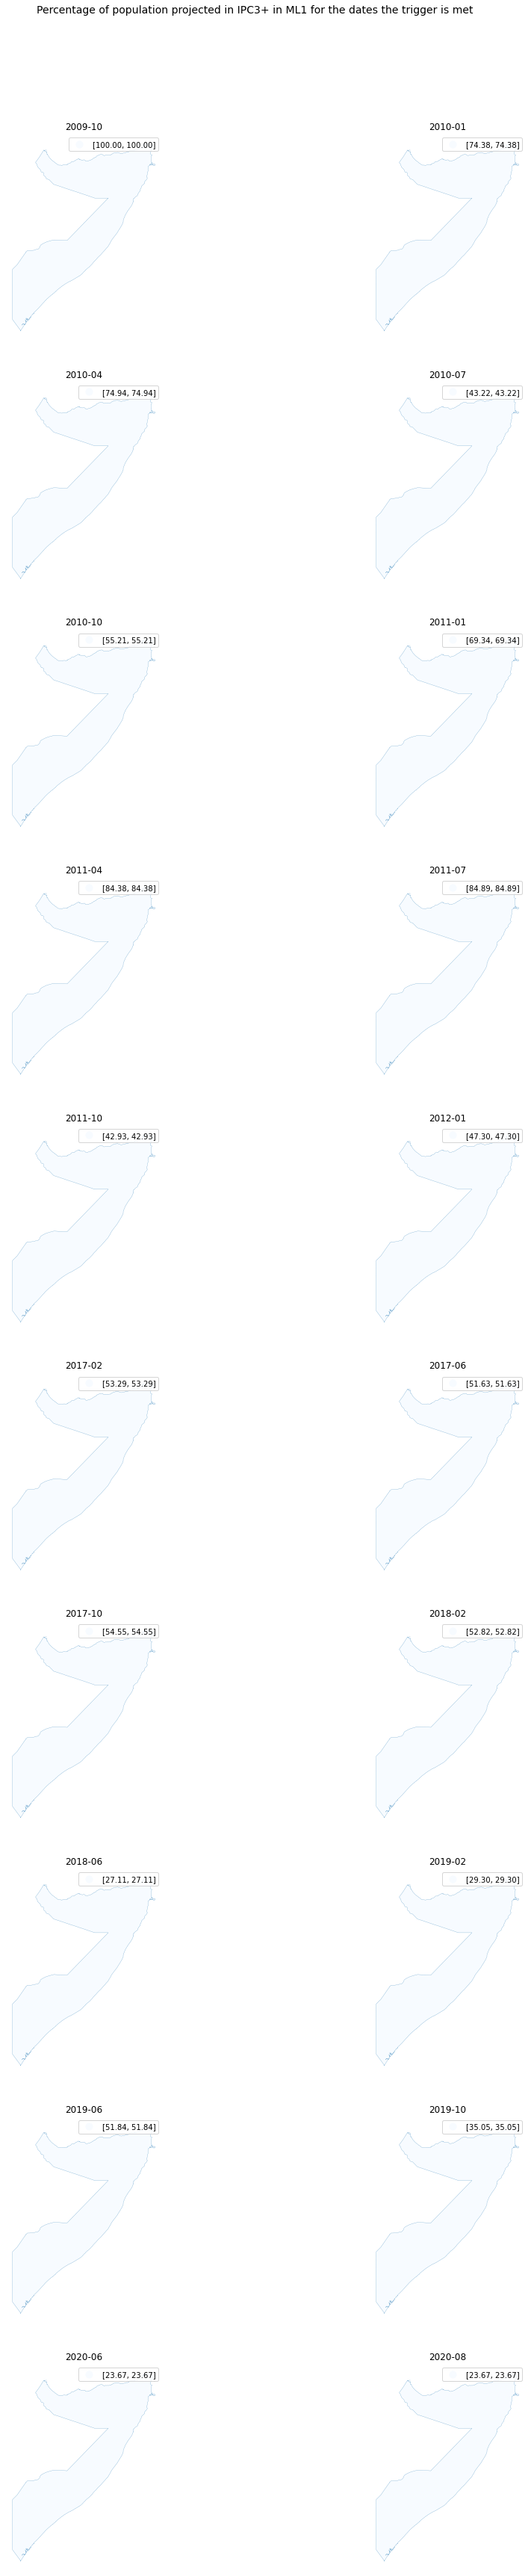

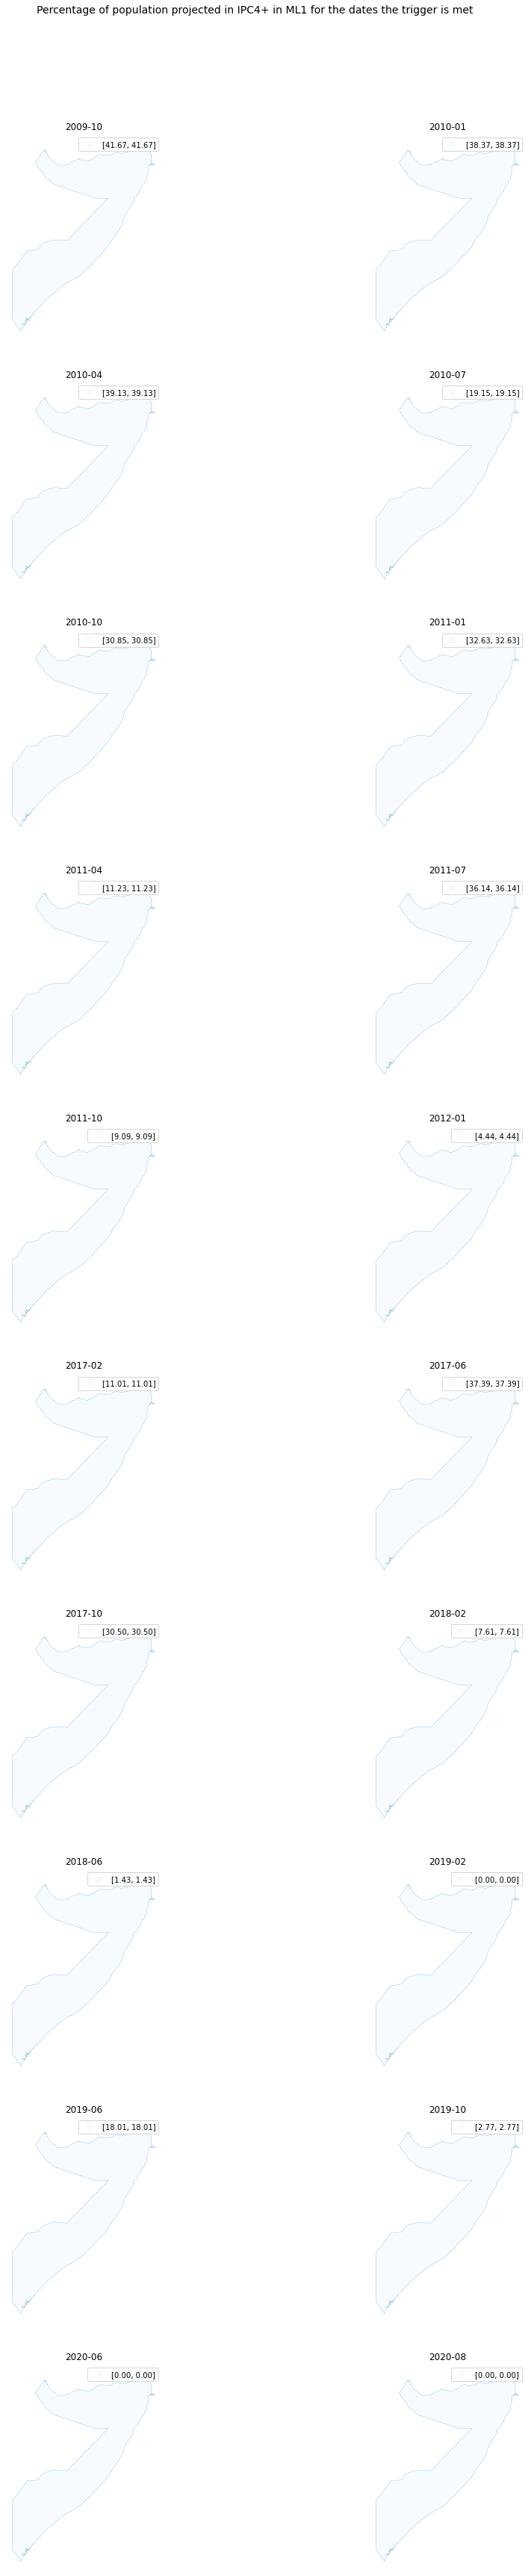

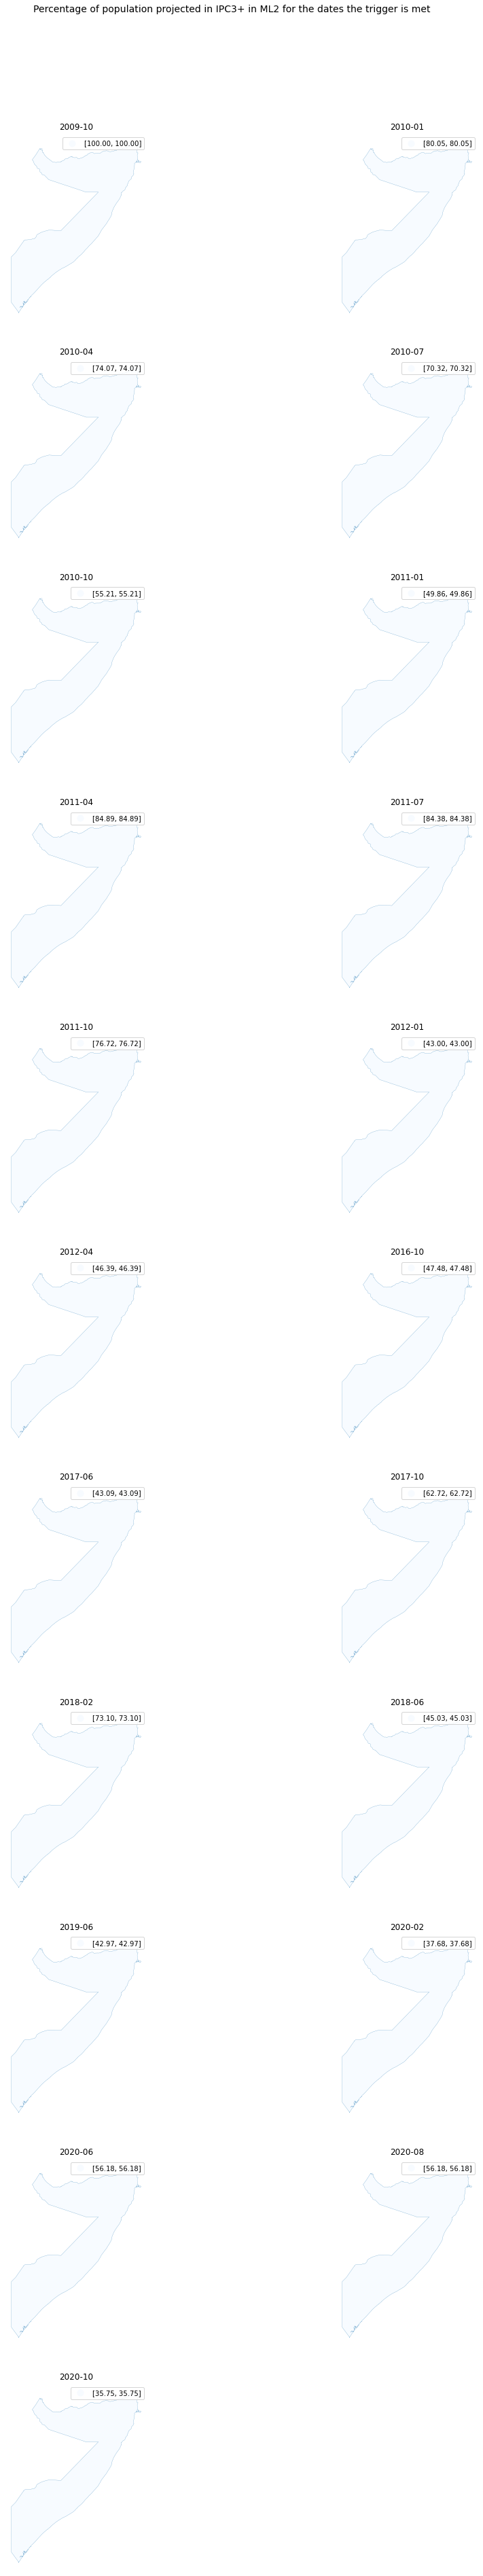

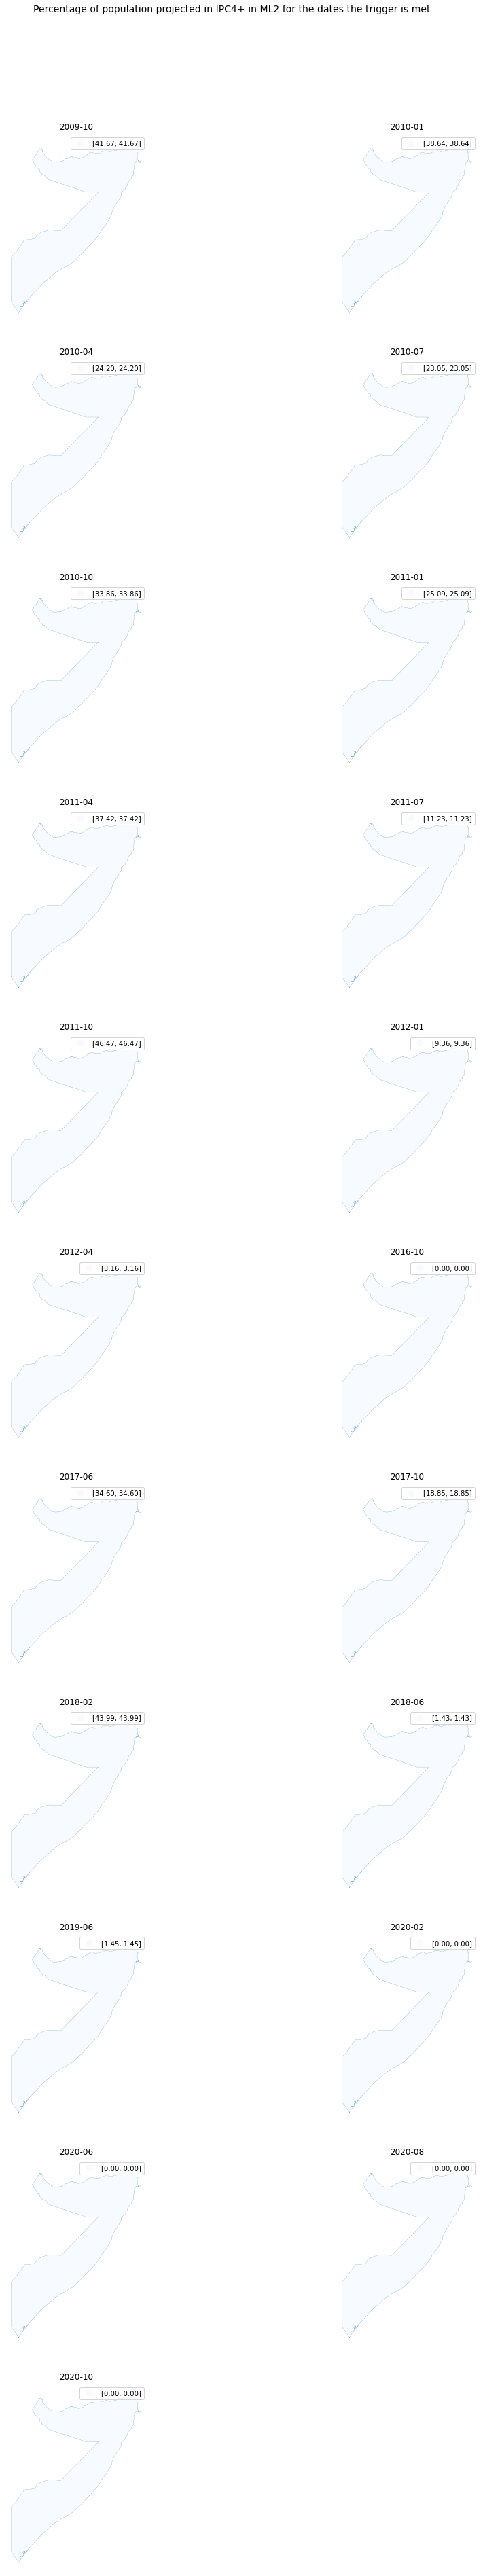

In [19]:
# plot percentage of country in IPC3+ or IPC4+

df_ntl['adm0c'] = country

plot_aff_dates(df_ntl, 
               dict_natl_activ["past_ML1"]["df"],"perc_ML1_3p",
               title="Percentage of population projected in IPC3+ in ML1 for the dates the trigger is met")

plot_aff_dates(df_ntl, 
               dict_natl_activ["past_ML1"]["df"],"perc_ML1_4",
               title="Percentage of population projected in IPC4+ in ML1 for the dates the trigger is met")

plot_aff_dates(df_ntl, 
               dict_natl_activ["past_ML2"]["df"],"perc_ML2_3p",
               title="Percentage of population projected in IPC3+ in ML2 for the dates the trigger is met")

plot_aff_dates(df_ntl, 
               dict_natl_activ["past_ML2"]["df"],"perc_ML2_4",
               title="Percentage of population projected in IPC4+ in ML2 for the dates the trigger is met")

### Subnational Trigger

- The projected regional population in Phase 3 and above exceed 20%, AND 
- The regional population in Phase 3 is projected to increase by 5 percentage points, OR 
- The projected regional population in Phase 4 or above is 2.5%

ML1 or ML2 projections not specified. Looking at both.

In [20]:
# regions that have been or were forecasted to be IPC 5
print("CS 5", df_fadm.CS_5.unique())
print("ML1 5", df_fadm.ML1_5.unique())

CS 5 [0.00000000e+00 4.63102929e+05 8.50107129e+03 1.52671190e+03
 1.72466488e+02 1.41567645e+06 3.51474960e+02 4.53750007e+05
 1.42462161e+04 1.00261855e+06 3.79671606e+02 2.11952087e+02
 1.13561153e+06 5.43193656e+02 3.27374351e+05]
ML1 5 [0.00000000e+00 5.10570223e+05 1.46448665e+06 1.02299113e+06
 5.41431109e+05 5.40856789e+05 6.27290330e+05 1.41743242e+06
 3.91416796e+05 8.49944475e+05 4.54150625e+05 5.47134036e+04
 1.00001002e+06 4.45067877e+02 1.03813635e+06 2.01005194e+02
 3.25500498e+05]


In [21]:
def add_columns(df):
    df["date"] = pd.to_datetime(df["date"])
    df["year"] = df["date"].dt.year
    df["month"] = df["date"].dt.month

    # calculate percentage of population per analysis period and level
    for period in ["CS", "ML1", "ML2"]:
        # IPC level goes up to 5, so define range up to 6
        for i in range(1, 6):
            c = f"{period}_{i}"
            df[f"perc_{c}"] = df[c] / df[f"pop_{period}"] * 100
        # get pop and perc in IPC3+ and IPC2-
        # 3p = IPC level 3 or higher, 2m = IPC level 2 or lower
        df[f"{period}_3p"] = df[[f"{period}_{i}" for i in range(3, 6)]].sum(axis=1)
        df[f"perc_{period}_3p"] = df[f"{period}_3p"] / df[f"pop_{period}"] * 100
        df[f"{period}_4p"] = df[[f"{period}_{i}" for i in range(4, 6)]].sum(axis=1)
        df[f"perc_{period}_4p"] = df[f"{period}_4p"] / df[f"pop_{period}"] * 100
        df[f"{period}_2m"] = df[[f"{period}_{i}" for i in range(1, 3)]].sum(axis=1)
        df[f"perc_{period}_2m"] = df[f"{period}_2m"] / df[f"pop_{period}"] * 100
    df["perc_inc_ML2_3p"] = df["perc_ML2_3p"] - df["perc_CS_3p"]
    df["perc_inc_ML1_3p"] = df["perc_ML1_3p"] - df["perc_CS_3p"]
    return df

In [22]:
df_fadm=add_columns(df_fadm)
df_fadm.head()

,date,ADMIN1,CS_2,CS_3,CS_4,CS_99,ML1_1,ML1_2,ML1_3,ML1_4,...,perc_ML2_4,perc_ML2_5,ML2_3p,perc_ML2_3p,ML2_4p,perc_ML2_4p,ML2_2m,perc_ML2_2m,perc_inc_ML2_3p,perc_inc_ML1_3p
0,2009-07-01,Awdal,20.72,0.00,0.00,463644.93,0.00,20.72,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,20.72,100.00,0.00,0.00
1,2009-07-01,Bakool,0.00,0.00,0.00,483539.54,0.00,0.00,0.00,0.00,...,nan,nan,0.00,nan,0.00,nan,0.00,nan,nan,nan
2,2009-07-01,Banadir,0.00,0.00,0.00,1388087.50,0.00,0.00,0.00,0.00,...,nan,nan,0.00,nan,0.00,nan,0.00,nan,nan,nan
3,2009-07-01,Bari,0.00,0.00,0.00,595480.55,0.00,0.00,0.00,0.00,...,nan,nan,0.00,nan,0.00,nan,0.00,nan,nan,nan
4,2009-07-01,Bay,0.00,0.00,0.00,968685.09,0.00,0.00,0.00,0.00,...,nan,nan,0.00,nan,0.00,nan,0.00,nan,nan,nan


In [24]:
def get_trigger(row, period, phase, threshold):
    """
    Return 1 if percentage of population in row for period in phase "phase" or higher, equals or larger than. 
    Threshold should NOT be a decimal (ie 5 for 5 percent, not .05) 
    """
    # range till 6 cause 5 is max phase
    cols = [f"perc_{period}_{l}" for l in range(phase, 6)]
    if np.isnan(row[f"pop_{period}"]):
        return np.nan
#    if round(row[cols].sum()/row[f"pop_{period}"]*100) >= threshold:
    if round(row[cols].sum()) >= threshold:
        return 1
    else:
        return 0


#def get_trigger_increase_rel(row, phase, threshold):
#    """
#    Return 1 if population in row for >="phase" at ML1 is expected to be larger than (current (CS) population in >=phase) * (1+(/100))
#    """
#    # range till 6 cause 5 is max phase
#    cols_ml1 = [f"ML1_{l}" for l in range(phase, 6)]
#    cols_cs = [f"CS_{l}" for l in range(phase, 6)]
#    if row[["pop_CS", "pop_ML1"]].isnull().values.any():
#        return np.nan
#    elif row[cols_ml1].sum() == 0:
#        return 0
#    elif row[cols_ml1].sum() > 0 and row[cols_cs].sum() == 0:
#       return 1
#    elif round((row[cols_ml1].sum() - row[cols_cs].sum())/row[cols_cs].sum() * 100) >= threshold:
#        return 1
#    else:
#        return 0
    
def get_trigger_increase(row, period, phase, threshold):
    """
    Return 1 if for row percentage in >="phase" at period minus percentage in >="phase" currently (CS) is expected to be larger than threshold
    For Global IPC the population analysed in ML2 is sometimes different than in CS. That is why we work directly with percentages and not anymore with (pop period phase+ - pop CS phase+) / pop CS
    Threshold should NOT be a decimal (ie 5 for 5 percent, not .05) 
    """
    # range till 6 cause 5 is max phase
    cols__ml = [f"perc_{period}_{l}" for l in range(phase, 6)]
    cols__cs = [f"perc_CS_{l}" for l in range(phase, 6)]
    if row[["pop_CS", f"pop_{period}"]].isnull().values.any():
        return np.nan
    if row[cols__ml].sum() == 0:
        return 0
    if round(row[cols__ml].sum() - row[cols__cs].sum()) >= threshold:
        return 1
    else:
        return 0

In [25]:
#display most recent numbers
df_fadm.loc[df_fadm.date==df_fadm.date.max(),["date",
                                              "year",
                                              "month",
                                              "ADMIN1",
                                              "perc_CS_3p",
                                              "perc_CS_4p",
                                              "perc_ML1_3p",
                                              "perc_ML1_4p",
                                              "perc_ML2_3p",
                                              "perc_ML2_4p"]]

,date,year,month,ADMIN1,perc_CS_3p,perc_CS_4p,perc_ML1_3p,perc_ML1_4p,perc_ML2_3p,perc_ML2_4p
720,2020-10-01,2020,10,Awdal,24.70,0.00,24.70,0.00,24.70,0.00
721,2020-10-01,2020,10,Bakool,28.77,0.00,28.77,0.00,28.77,0.00
722,2020-10-01,2020,10,Banadir,0.00,0.00,0.00,0.00,98.95,0.00
723,2020-10-01,2020,10,Bari,100.00,0.00,100.00,0.00,100.00,0.00
724,2020-10-01,2020,10,Bay,34.62,0.00,34.62,0.00,34.62,0.00
725,2020-10-01,2020,10,Galgaduud,0.00,0.00,0.00,0.00,22.82,0.00
726,2020-10-01,2020,10,Gedo,0.00,0.00,0.00,0.00,0.00,0.00
727,2020-10-01,2020,10,Hiraan,19.85,0.00,19.85,0.00,42.01,0.00
728,2020-10-01,2020,10,Lower Juba,30.63,0.00,30.63,0.00,30.63,0.00
729,2020-10-01,2020,10,Lower Shabelle,0.27,0.00,0.27,0.00,0.27,0.00


In [26]:
#Column value for row will be 1 if threshold is met and 0 if it isnt
#The projected population in phase 3 and above exceed 20%, AND
#The projected population in phase 3 is projected to increase by a further 5%, OR
#The projected population in phase 4 or above is 2.5%

df_fadm["trigger_ML1_3_20"]=df_fadm.apply(lambda x: get_trigger(x,"ML1",3,20),axis=1)
df_fadm["trigger_ML1_3_5ir"]=df_fadm.apply(lambda x: get_trigger_increase(x,"ML1",3,5),axis=1)
df_fadm["trigger_ML1_4_2half"]=df_fadm.apply(lambda x: get_trigger(x,"ML1",4,2.5),axis=1)

df_fadm["trigger_ML2_3_20"]=df_fadm.apply(lambda x: get_trigger(x,"ML2",3,20),axis=1)
df_fadm["trigger_ML2_3_5ir"]=df_fadm.apply(lambda x: get_trigger_increase(x,"ML2",3,5),axis=1)
df_fadm["trigger_ML2_4_2half"]=df_fadm.apply(lambda x: get_trigger(x,"ML2",4,2.5),axis=1)



In [27]:
#analyse endorsed trigger applied at subnational level
subnatl_activations_ML1=df_fadm.loc[((df_fadm["trigger_ML1_3_20"]==1) & (df_fadm["trigger_ML1_3_5ir"]==1)) | (df_fadm["trigger_ML1_4_2half"]==1)]
subnatl_activations_ML2=df_fadm.loc[((df_fadm["trigger_ML2_3_20"]==1) & (df_fadm["trigger_ML2_3_5ir"]==1)) | (df_fadm["trigger_ML2_4_2half"]==1)]

display(subnatl_activations_ML1.groupby(['year', 'month'], as_index=False)[admc,'perc_CS_3p','perc_ML1_3p','perc_ML1_4p'].agg(lambda x: list(x)))
display(subnatl_activations_ML2.groupby(['year', 'month'], as_index=False)[admc,'perc_CS_3p','perc_ML2_3p','perc_ML2_4p'].agg(lambda x: list(x)))


,year,month,ADMIN1,perc_CS_3p,perc_ML1_3p,perc_ML1_4p
0,2009,10,"[Bakool, Banadir, Bay, Galgaduud, Gedo, Hiraan...","[100.0, 100.0, 100.0, 100.0, 100.0000000000000...","[100.0, 100.0, 100.0, 100.0, 100.0000000000000...","[100.0, 96.99964006790977, 13.71673989310948, ..."
1,2010,1,"[Bakool, Banadir, Galgaduud, Gedo, Hiraan, Mid...","[100.0, 99.92290134516996, 100.0, 81.251498583...","[100.0, 99.92290134516996, 100.0, 81.251498583...","[37.65495933105403, 96.71650337608632, 100.0, ..."
2,2010,4,"[Bakool, Banadir, Galgaduud, Gedo, Hiraan, Mid...","[100.00000000000003, 99.92290134516996, 100.0,...","[100.00000000000003, 99.92290134516996, 100.0,...","[79.5484677298544, 96.71650337608632, 100.0, 6..."
3,2010,7,"[Bakool, Banadir, Galgaduud, Lower Shabelle, M...","[99.99999999999999, 99.92290134178798, 100.0, ...","[99.99999999999999, 99.92290134178798, 100.0, ...","[90.29316921072204, 96.84993807461116, 35.2914..."
4,2010,10,"[Bakool, Banadir, Bari, Galgaduud, Gedo, Hiraa...","[100.0, 99.40470934516016, 62.82575964465262, ...","[100.0, 99.40470934516016, 79.37899600341673, ...","[36.6228422937073, 96.49617061256029, 0.0, 93...."
5,2011,1,"[Bakool, Banadir, Bari, Bay, Galgaduud, Gedo, ...","[100.00000000000003, 99.41951869152433, 61.949...","[99.99999999999997, 99.70975934576217, 100.0, ...","[37.05882392069352, 96.54159172505729, 4.83298..."
6,2011,4,"[Bakool, Banadir, Bari, Bay, Galgaduud, Gedo, ...","[100.00000000000003, 99.41951869152433, 61.949...","[100.0, 100.0, 99.0102059986873, 100.0, 100.0,...","[100.0, 100.0, 4.832987455109811, 100.0, 100.0..."
7,2011,7,"[Bakool, Banadir, Bari, Bay, Galgaduud, Gedo, ...","[100.00000000000003, 100.0, 99.0102059986873, ...","[100.00000000000003, 100.0, 99.99999999999997,...","[100.00000000000003, 100.0, 4.833731476557789,..."
8,2011,10,"[Bari, Galgaduud, Gedo, Hiraan, Lower Juba, Mi...","[99.01020600671492, 100.0, 100.0, 100.0, 99.99...","[25.47378137388162, 64.42248824126379, 51.6761...","[4.836058346245499, 6.03182625986707, 22.79201..."
9,2012,1,"[Banadir, Bari, Galgaduud, Hiraan, Lower Juba,...","[0.2634265888894306, 25.72787053001439, 64.471...","[99.68948944160049, 25.72787053001439, 25.4164...","[0.0, 5.351552014020124, 6.399672191526502, 28..."


,year,month,ADMIN1,perc_CS_3p,perc_ML2_3p,perc_ML2_4p
0,2009,10,"[Bakool, Banadir, Bay, Galgaduud, Gedo, Hiraan...","[100.0, 100.0, 100.0, 100.0, 100.0000000000000...","[100.0, 100.0, 100.0, 100.0, 100.0000000000000...","[100.0, 96.99964006790977, 13.71673989310948, ..."
1,2010,1,"[Awdal, Bakool, Banadir, Bari, Galgaduud, Gedo...","[57.97915792236532, 100.0, 99.92290134516996, ...","[100.0, 100.0, 99.92290134516996, 100.0, 100.0...","[0.0036839039572421814, 37.65495933105403, 96...."
2,2010,4,"[Banadir, Galgaduud, Hiraan, Mudug, Nugaal, Sa...","[99.92290134516996, 100.0, 100.0, 100.0, 99.95...","[99.92290134051973, 100.0, 100.00000000000003,...","[96.33174626625265, 74.55522166771067, 99.9479..."
3,2010,7,"[Awdal, Bakool, Banadir, Bari, Galgaduud, Lowe...","[0.0036839039572421814, 99.99999999999999, 99....","[99.99631609604276, 100.00000000000003, 99.922...","[0.0, 90.29316920933587, 96.84993807461116, 0...."
4,2010,10,"[Bakool, Banadir, Bari, Galgaduud, Gedo, Hiraa...","[100.0, 99.40470934516016, 62.82575964465262, ...","[100.0, 99.40470934516016, 79.37899600341673, ...","[36.6228422937073, 96.49617061256029, 0.0, 93...."
5,2011,1,"[Bakool, Banadir, Bari, Galgaduud, Gedo, Hiraa...","[100.00000000000003, 99.41951869152433, 61.949...","[100.00000000000003, 99.41951869152433, 79.359...","[37.058823920693534, 96.42689837369393, 4.8329..."
6,2011,4,"[Bakool, Banadir, Bari, Bay, Galgaduud, Gedo, ...","[100.00000000000003, 99.41951869152433, 61.949...","[100.00000000000003, 100.0, 100.0, 99.99999999...","[37.058823920693534, 96.65628507642064, 4.8329..."
7,2011,7,"[Bakool, Banadir, Bari, Bay, Galgaduud, Gedo, ...","[100.00000000000003, 100.0, 99.0102059986873, ...","[100.0, 100.0, 99.0102059986873, 100.0, 100.0,...","[100.0, 100.0, 4.832987455109811, 100.0, 100.0..."
8,2011,10,"[Bakool, Banadir, Bari, Bay, Galgaduud, Gedo, ...","[100.00000000000003, 100.0, 99.01020600671492,...","[100.00000000000003, 100.0, 99.99999999999997,...","[88.94968807033774, 100.0, 4.833731476557789, ..."
9,2012,1,"[Bari, Bay, Galgaduud, Gedo, Hiraan, Lower Jub...","[25.72787053001439, 40.07870767857976, 64.4718...","[25.72787053001439, 99.97115455929682, 64.4718...","[5.351552014020124, 0.004863594253668201, 6.39..."


In [28]:
# create dict with activations based on ML1 and ML2
dict_subnatl_activ={}


dict_subnatl_activ["subnatl_ML1"]={"df": subnatl_activations_ML1,
                                   "trig_cols":["CS_3p","ML1_3p","ML1_4p"],
                                   "desc":"At least 20% of ADMIN1 population in IPC3+ at ML1 AND increase by 5 percentage points in ADMIN1 pop. projected in IPC3+ compared to current state) OR (At least 2.5% of ADMIN1 population projected at IPC4+ by ML1"}

dict_subnatl_activ["subnatl_ML2"]={"df": subnatl_activations_ML2,
                                   "trig_cols":["CS_3p","ML1_3p","ML1_4p"],
                                   "desc":"At least 20% of ADMIN1 population in IPC3+ at ML2 AND increase by 5 percentage points in ADMIN1 pop. projected in IPC3+ compared to current state) OR (At least 2.5% of ADMIN1 population projected at IPC4+ by ML2"}

dict_subnatl_activ

{'subnatl_ML1': {'df':           date     ADMIN1       CS_2      CS_3       CS_4  CS_99    ML1_1  \
  19  2009-10-01     Bakool       0.00      0.00  483539.54    nan     0.00   
  20  2009-10-01    Banadir       0.00  41647.62 1346439.75    nan     0.00   
  22  2009-10-01        Bay       0.00 835813.09  132872.02    nan     0.00   
  23  2009-10-01  Galgaduud       0.00      0.00  514325.13    nan     0.00   
  24  2009-10-01       Gedo       0.00 199486.79  313059.65    nan     0.00   
  ..         ...        ...        ...       ...        ...    ...      ...   
  698 2020-06-01     Sanaag  569674.81      0.00       0.00    nan     0.00   
  703 2020-08-01     Bakool  577497.14      0.00       0.00    nan 77503.64   
  705 2020-08-01       Bari  809357.58      0.00       0.00    nan     0.00   
  706 2020-08-01        Bay 1288131.55    841.59       0.00    nan 23731.47   
  716 2020-08-01     Sanaag  569674.81      0.00       0.00    nan     0.00   
  
           ML1_2     ML1_3  

### FewsNet, plotting characteristics of the trigger

In [29]:
def plot_regions_trig(df_trig,adm0c="admin0Name",adm1c="admin1Name",shape_path="../Data/som_adm_undp_shp/Som_Admbnda_Adm1_UNDP.shp"):
    gdf = gpd.read_file(shape_path)

    count = 1
    f, ax = plt.subplots(figsize=(12,12))
    for d in range(2009,2021):
        ax2 = plt.subplot(4, 4, count)
        gdf.plot(ax=ax2, color='#DDDDDD', edgecolor='#BBBBBB')
        regions = df_trig['ADMIN1'].loc[df_trig['year']==d]
        if len(regions) > 0:
            gdf.loc[gdf[adm1c].isin(regions)].plot(ax=ax2, color='red')
        plt.title(f"Regions triggered {d}")
        count+=1
        ax2.axis("off")
    plt.show()

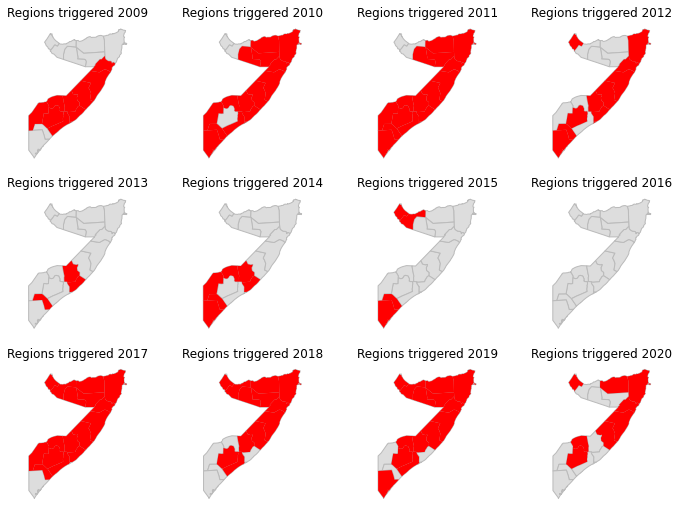

In [30]:
plot_regions_trig(dict_subnatl_activ["subnatl_ML1"]["df"])

In [31]:
def plot_aff_dates(df_d,df_trig,col,shape_path="../Data/som_adm_undp_shp/Som_Admbnda_Adm1_UNDP.shp",title=None,predef_bins=None):
    """
    Plot the values of "col" for the dates present in df_trig
    If giving predef_bins then the data will be colored according to the bins, else a different colour will be assigned to each unique value in the data for each date
    df_d: DataFrame containing all the data of all regions
    df_trig: DataFrame containing the dates for which plots should be shown (generally those dates that the trigger is met)
    col: string with column to plot
    shape_path: relative path to the admin1 shapefile
    title: string with title of whole figure (so not the subplots)
    predef_bins: list with bin values
    """
    
    num_plots=len(df_trig.date.unique())
    colp_num=2
    rows=num_plots // colp_num
    rows+=num_plots % colp_num
    position = range(1, num_plots + 1)

    gdf = gpd.read_file(shape_path)
    df_geo=gdf[["admin1Name","geometry"]].merge(df_d,left_on="admin1Name",right_on="ADMIN1",how="left")
    
    cmap = 'YlOrRd' #'Blues'
    if predef_bins is not None:
        scheme = None 
        norm2 = mcolors.BoundaryNorm(boundaries=predef_bins, ncolors=256)
    else:
        scheme="natural_breaks"
        norm2=None 
    
    figsize = (16, 10)
    fig = plt.figure(1,figsize=(16,6*rows))
    
    for i,c in enumerate(df_trig.date.unique()):
        ax = fig.add_subplot(rows,colp_num,position[i])
        
        if predef_bins is None:
            colors = len(df_geo[col].unique())
        else:
            colors=None
        
        df_date=df_geo[df_geo.date==c]
        if df_date[col].isnull().values.all():
            print(f"No not-NaN values for {c}")
        elif df_date[col].isnull().values.any():
            df_date.plot(col, ax=ax,cmap=cmap, figsize=figsize, k = colors, norm=norm2, legend=True,scheme=scheme,missing_kwds={"color": "lightgrey", "edgecolor": "red",
   "hatch": "///",
    "label": "Missing values"})
        else:
            df_date.plot(col, ax=ax,cmap=cmap, figsize=figsize, k = colors, norm=norm2, legend=True,scheme=scheme)
        df_geo.boundary.plot(linewidth=0.2,ax=ax)

        ax.axis("off")
        
        
        if predef_bins is None and not df_date[col].isnull().values.all():
            leg = ax.get_legend()

            for lbl in leg.get_texts():
                label_text = lbl.get_text()
                upper = label_text.split(",")[-1].rstrip(']')

                try:
                    new_text = f'{float(upper):,.2f}'
                except:
                    new_text=upper
                lbl.set_text(new_text)
        
        plt.title(pd.DatetimeIndex([c])[0].to_period('M'))
    if title:
        fig.suptitle(title,fontsize=14, y=0.92)
    plt.show()

In [32]:
#end value is not included, so set one higher than max value of last bin
bins=np.arange(0,101,10)
print(bins)

[  0  10  20  30  40  50  60  70  80  90 100]


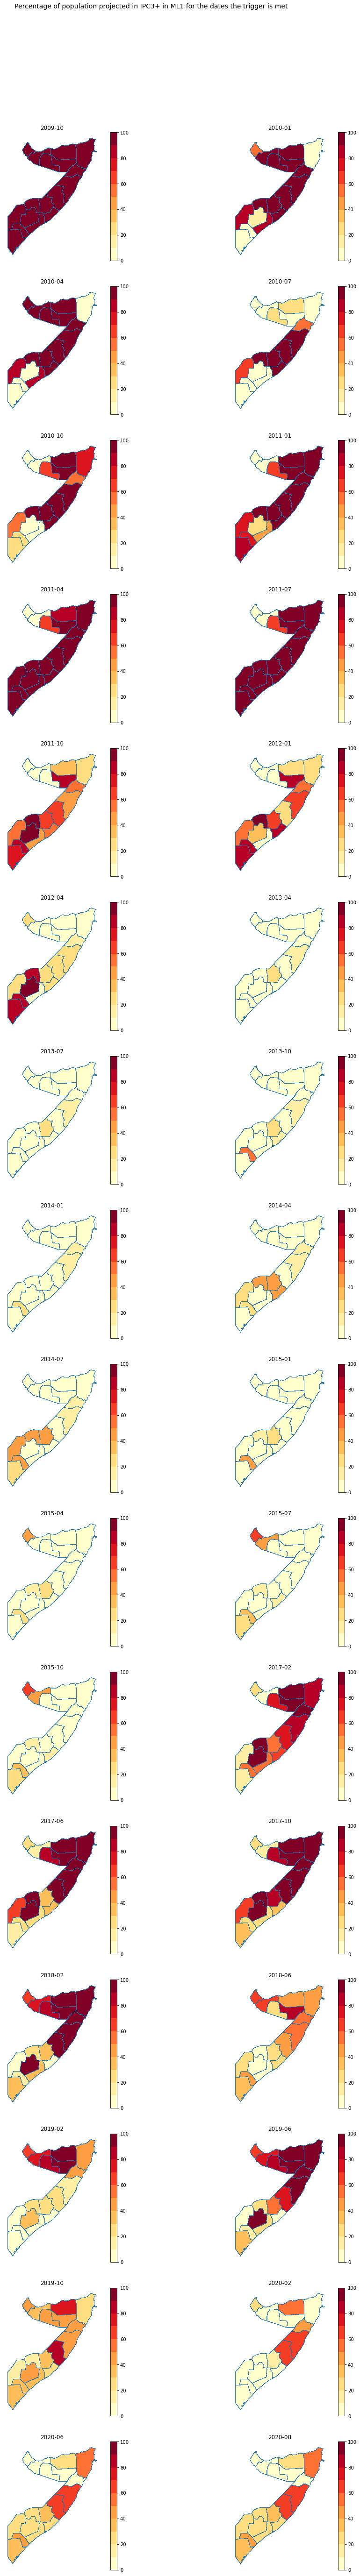

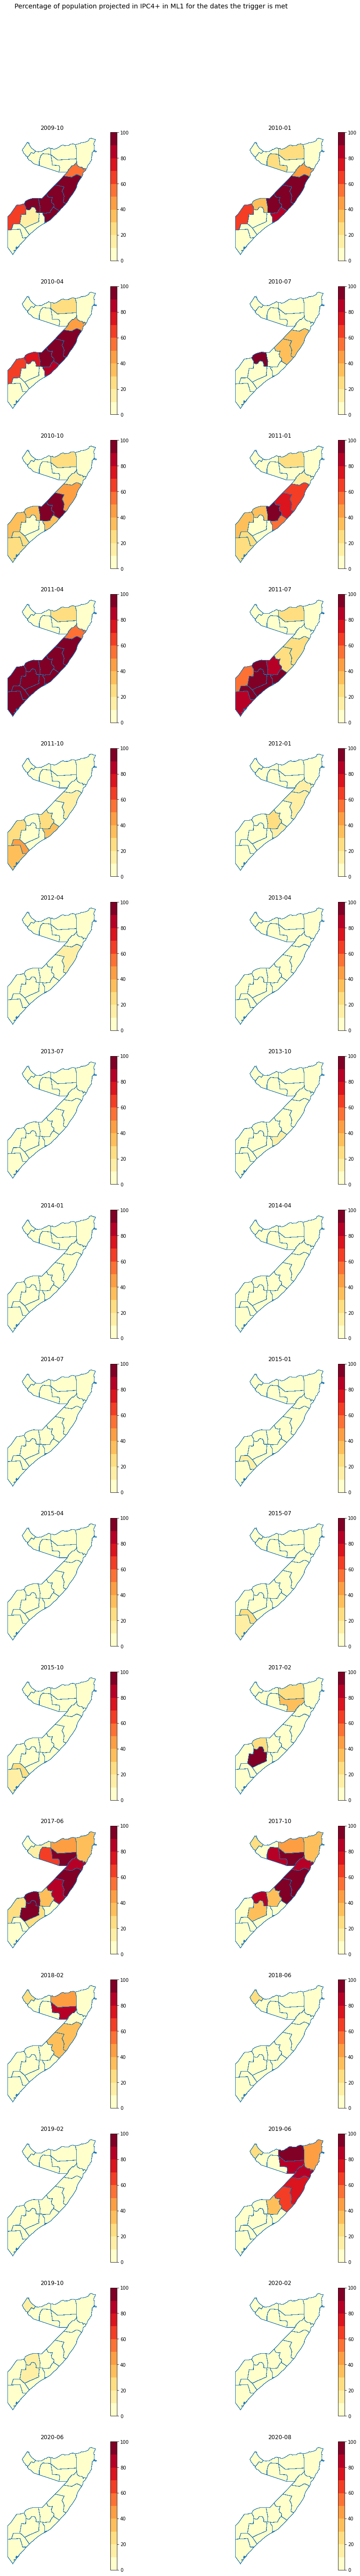

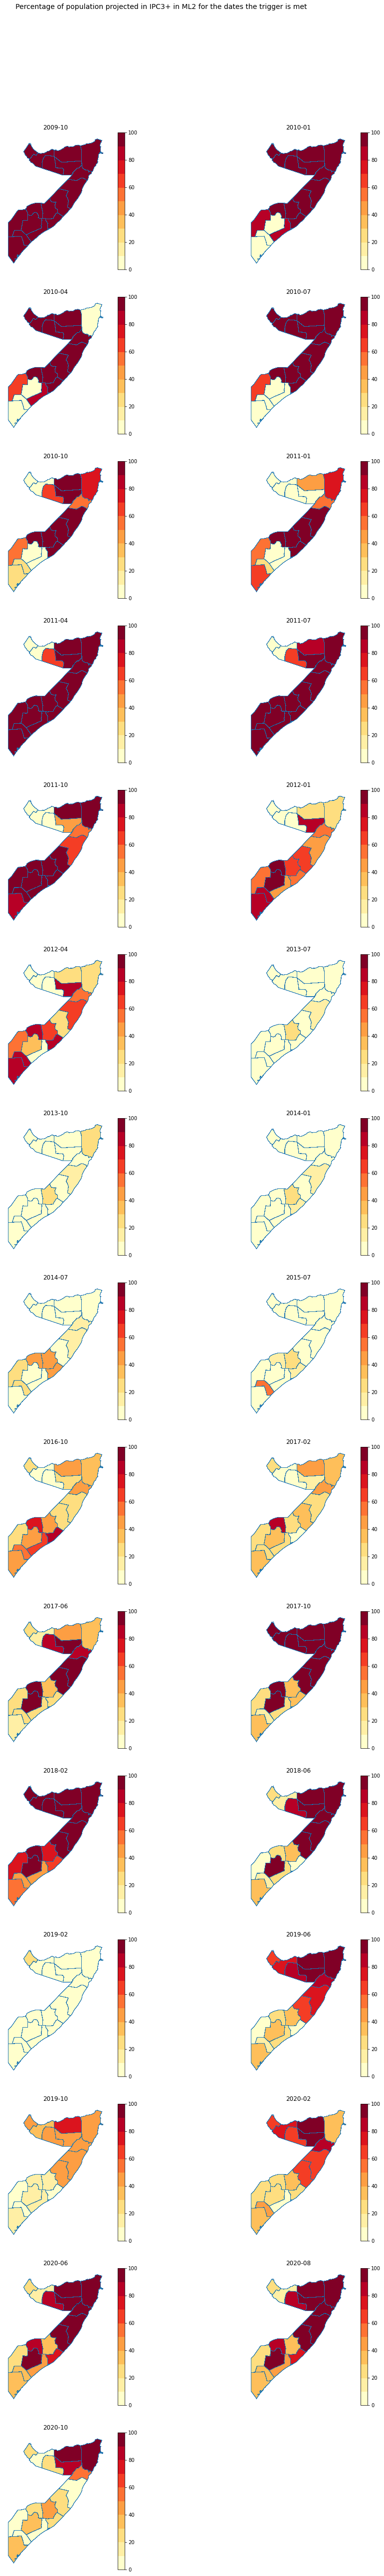

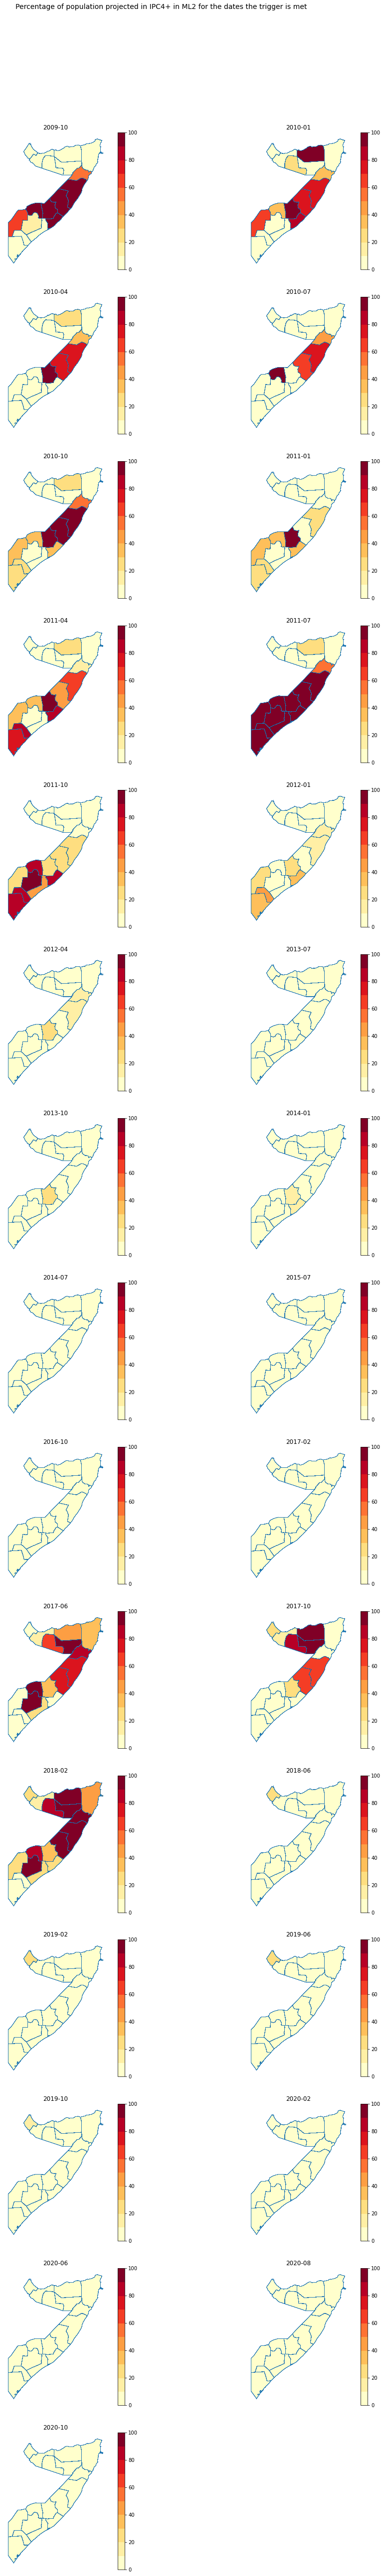

In [33]:
plot_aff_dates(df_fadm, 
               dict_subnatl_activ["subnatl_ML1"]["df"],
               "perc_ML1_3p",
               title="Percentage of population projected in IPC3+ in ML1 for the dates the trigger is met",
               predef_bins=bins)

plot_aff_dates(df_fadm, 
               dict_subnatl_activ["subnatl_ML1"]["df"],
               "perc_ML1_4p",
               title="Percentage of population projected in IPC4+ in ML1 for the dates the trigger is met",
               predef_bins=bins)

plot_aff_dates(df_fadm, 
               dict_subnatl_activ["subnatl_ML2"]["df"],
               "perc_ML2_3p",
               title="Percentage of population projected in IPC3+ in ML2 for the dates the trigger is met",
               predef_bins=bins)

plot_aff_dates(df_fadm, 
               dict_subnatl_activ["subnatl_ML2"]["df"],
               "perc_ML2_4p",
               title="Percentage of population projected in IPC4+ in ML2 for the dates the trigger is met",
               predef_bins=bins)

#### Trigger analysis Global IPC data
Besides FewsNet, there is also Global IPC data for Somalia available from 2017 onwards. During the analysis we realized that the aggregated subnational figures don't equal the national figures. Hence, the analysis directly on the national data and the aggregated national data is shown. Moreover, the trigger on subnational level is analyzed

In [34]:
df_gadm=pd.read_csv(f"../Data/GlobalIPCProcessed/{country}_globalipc_admin1.csv",index_col=0)

In [35]:
glob_adm1c="ADMIN1"

In [36]:
df_gadm=add_columns(df_gadm)

In [37]:
df_gadm.head(n=3)

,date,ADMIN1,CS_1,CS_2,CS_3,CS_4,CS_5,ML1_1,ML1_2,ML1_3,...,perc_ML2_4,perc_ML2_5,ML2_3p,perc_ML2_3p,ML2_4p,perc_ML2_4p,ML2_2m,perc_ML2_2m,perc_inc_ML2_3p,perc_inc_ML1_3p
0,2019-08-01,Awdal,340865.00,273307.00,42014.00,21823.00,0.00,281453.00,262990.00,87159.00,...,nan,nan,0.00,nan,0.00,nan,0.00,nan,nan,8.91
1,2017-01-01,Awdal,483122.00,117913.00,72230.00,0.00,0.00,452623.00,129712.00,80503.00,...,nan,nan,0.00,nan,0.00,nan,0.00,nan,nan,2.93
2,2018-01-01,Awdal,500540.00,66935.00,68868.00,36922.00,0.00,375401.00,123859.00,102784.00,...,nan,nan,0.00,nan,0.00,nan,0.00,nan,nan,10.28


In [38]:
#Column value for row will be 1 if threshold is met and 0 if it isnt
#The projected population in phase 3 and above exceed 20%, AND
#The projected population in phase 3 is projected to increase by a further 5%, OR
#The projected population in phase 4 or above is 2.5%

df_gadm["trigger_ML1_3_20"]=df_gadm.apply(lambda x: get_trigger(x,"ML1",3,20),axis=1)
df_gadm["trigger_ML1_3_5ir"]=df_gadm.apply(lambda x: get_trigger_increase(x,"ML1",3,5),axis=1)
df_gadm["trigger_ML1_4_2half"]=df_gadm.apply(lambda x: get_trigger(x,"ML1",4,2.5),axis=1)

df_gadm["trigger_ML2_3_20"]=df_gadm.apply(lambda x: get_trigger(x,"ML2",3,20),axis=1)
df_gadm["trigger_ML2_3_5ir"]=df_gadm.apply(lambda x: get_trigger_increase(x,"ML2",3,5),axis=1)
df_gadm["trigger_ML2_4_2half"]=df_gadm.apply(lambda x: get_trigger(x,"ML2",4,2.5),axis=1)



In [39]:
#analyse endorsed trigger applied at subnational level
glob_subnatl_activations_ML1=df_gadm.loc[((df_gadm["trigger_ML1_3_20"]==1) & (df_gadm["trigger_ML1_3_5ir"]==1)) | (df_gadm["trigger_ML1_4_2half"]==1)]
glob_subnatl_activations_ML2=df_gadm.loc[((df_gadm["trigger_ML2_3_20"]==1) & (df_gadm["trigger_ML2_3_5ir"]==1)) | (df_gadm["trigger_ML2_4_2half"]==1)]

display(glob_subnatl_activations_ML1.groupby(['year', 'month'], as_index=False)[admc,'perc_CS_3p','perc_ML1_3p','perc_ML1_4p'].agg(lambda x: list(x)))
display(glob_subnatl_activations_ML2.groupby(['year', 'month'], as_index=False)[admc,'perc_CS_3p','perc_ML2_3p','perc_ML2_4p'].agg(lambda x: list(x)))


,year,month,ADMIN1,perc_CS_3p,perc_ML1_3p,perc_ML1_4p
0,2017,1,"[Bakool, Bari, Bay, Galgaduud, Hiraan, Mudug, ...","[31.273299621215216, 6.851360068588928, 25.527...","[41.92856189768182, 20.95002787109993, 38.4886...","[13.663211038404038, 1.8627755780685258, 19.23..."
1,2017,7,[Bari],[9.574921214495163],[27.936429239591483],[4.551823126028046]
2,2018,1,"[Awdal, Bari, Bay, Galgaduud, Hiraan, Mudug, N...","[15.713004111314433, 5.617772859437894, 8.0535...","[25.994854915753702, 10.609370441842533, 25.57...","[10.728332422348439, 3.1496397300817507, 0.0, ..."
3,2018,7,"[Awdal, Bari]","[22.350222201097935, 19.429375180614315]","[23.242888376624922, 27.81275551361575]","[5.297921766201668, 4.58798022863889]"
4,2019,1,"[Awdal, Banadir, Bay, Sanaag, Sool]","[25.464453765536256, 5.000036358612264, 14.633...","[25.893854416692413, 9.000029086889812, 23.946...","[4.564034316404857, 3.000009695629937, 1.70402..."
5,2019,8,"[Awdal, Bakool, Banadir, Bay, Hiraan, Juba Hoo...","[9.481718909669906, 12.29021831183437, 6.00001...","[18.39545854226574, 15.27937760567714, 12.0000...","[5.449719575084959, 6.808867539696155, 3.00000..."
6,2020,1,"[Bay, Galgaduud, Gedo, Mudug]","[10.81963146704465, 16.771269421634422, 13.666...","[14.472005669737776, 18.094523490623153, 15.49...","[3.2084809827545477, 2.7909651269608635, 4.218..."
7,2020,9,"[Awdal, Bakool, Bari, Bay, Gedo, Hiraan, Nugaa...","[11.959181476538596, 9.642943805762556, 15.599...","[18.760152531214935, 13.37105639820927, 22.607...","[5.165663087087154, 2.520810401156309, 4.67995..."


""


Global IPC on national level by aggregating subnational data

In [40]:
df_gntl=df_gadm.groupby("date",as_index=False).sum()

In [41]:
df_gntl=add_percentages(df_gntl)

In [42]:
df_gntl.head(n=3)

,date,CS_1,CS_2,CS_3,CS_4,CS_5,ML1_1,ML1_2,ML1_3,ML1_4,...,ML2_2m,perc_ML2_2m,perc_inc_ML2_3p,perc_inc_ML1_3p,trigger_ML1_3_20,trigger_ML1_3_5ir,trigger_ML1_4_2half,trigger_ML2_3_20,trigger_ML2_3_5ir,trigger_ML2_4_2half
0,2017-01-01,8131797.00,2950989.00,1158034.00,44791.00,0.00,7138570.00,2733120.00,2003740.00,384130.00,...,0.00,0.00,nan,9.66,8,15,6,0,0,0
1,2017-07-01,7015439.00,2434728.00,1966338.00,667991.00,0.00,7693831.00,3081562.00,1342242.00,134987.00,...,0.00,0.00,nan,-9.77,2,1,1,0,0,0
2,2018-01-01,8621010.00,2153272.00,1184113.00,149238.00,0.00,7683897.00,2220646.00,1771717.00,429658.00,...,0.00,0.00,nan,7.17,9,11,10,0,0,0


In [43]:
# apply criteria. Returns 1 if criterion is met.

df_gntl["natl_criterion_ML1_3_20"] = df_gntl.apply(lambda x: get_national_abs_criterion(x,"ML1",3,20),axis=1)
df_gntl["natl_criterion_ML1_3_5in"] = df_gntl.apply(lambda x: get_national_increase_criterion(x,"ML1",3,5),axis=1)
df_gntl["natl_criterion_ML1_4_2half"] = df_gntl.apply(lambda x: get_national_abs_criterion(x,"ML1",4,2.5),axis=1)

df_gntl["natl_criterion_ML2_3_20"] = df_gntl.apply(lambda x: get_national_abs_criterion(x,"ML2",3,20),axis=1)
df_gntl["natl_criterion_ML2_3_5in"] = df_gntl.apply(lambda x: get_national_increase_criterion(x,"ML2",3,5),axis=1)
df_gntl["natl_criterion_ML2_4_2half"] = df_gntl.apply(lambda x: get_national_abs_criterion(x,"ML2",4,2.5),axis=1)


In [44]:
# determine whether national trigger is met

df_gntl['national_trigger_ML1'] =  np.where((df_gntl['natl_criterion_ML1_3_20'] & df_gntl['natl_criterion_ML1_3_5in'] ) | (df_gntl['natl_criterion_ML1_4_2half'] == 1), 1, 0)
df_gntl['national_trigger_ML2'] =  np.where((df_gntl['natl_criterion_ML2_3_20'] & df_gntl['natl_criterion_ML2_3_5in'] ) | (df_gntl['natl_criterion_ML2_4_2half'] == 1), 1, 0)

In [45]:
# extract year / month per row

df_gntl["date"] = pd.to_datetime(df_gntl["date"])
df_gntl["year"] = df_gntl["date"].dt.year
df_gntl["month"] = df_gntl["date"].dt.month

In [46]:
# list years / months during which national trigger would have been met

national_activations_ML1 = df_gntl.loc[(df_gntl["national_trigger_ML1"] == 1)]
national_activations_ML1['period'] = 'ML1'
national_activations_ML1['adm0c'] = country

national_activations_ML2 = df_gntl.loc[(df_gntl["national_trigger_ML2"] == 1)]
national_activations_ML2['period'] = 'ML2'
national_activations_ML2['adm0c'] = country

activation_frames = [national_activations_ML1, national_activations_ML2]
national_activations = pd.concat(activation_frames)

display(national_activations_ML1.round(2).groupby(['year', 'month'], as_index=False)['period','perc_CS_3p','perc_CS_4','perc_ML1_3p','perc_ML1_4'].agg(lambda x: list(x)))
display(national_activations_ML2.round(2).groupby(['year', 'month'], as_index=False)['period','perc_CS_3p','perc_CS_4','perc_ML2_3p','perc_ML2_4'].agg(lambda x: list(x)))


,year,month,period,perc_CS_3p,perc_CS_4,perc_ML1_3p,perc_ML1_4
0,2017,1,[ML1],[9.8],[0.36],[19.46],[3.13]
1,2018,1,[ML1],[11.01],[1.23],[18.18],[3.55]
2,2019,8,[ML1],[9.73],[1.82],[16.91],[3.52]
3,2020,9,[ML1],[10.39],[2.42],[17.06],[3.25]


""


GlobalIPC on national level, by directly using the reported national numbers

In [47]:
df_gntl_noagg=pd.read_excel("../Data/GlobalIPC/SOM_globalipc_newcolumnnames.xlsx",index_col=0)

In [48]:
df_gntl_noagg.head(n=2)

,ADMIN0,ADMIN1,ADMIN2,ADMIN2_ID,Analysis Name,date,Country Population,pop_CS,% of total county Pop,Area Phase,...,ML2_2,perc_ML2_2,ML2_3,perc_ML2_3,ML2_4,perc_ML2_4,ML2_5,perc_ML2_5,ML2_3p,perc_ML2_3p
0,Somalia: Acute Food Insecurity August 2020,NaN,NaN,nan,NaN,Sep 2020,12327530.00,12327530.00,1.00,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1,Awdal,NaN,NaN,nan,NaN,Sep 2020,nan,724573.00,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [49]:
#remove rows with nanvalues as date
df_gntl_noagg = df_gntl_noagg[(df_gntl_noagg["date"].notnull()) & (df_gntl_noagg[f"ADMIN0"].notnull())]

In [50]:
#rows with country and then a colon, indicate the numbers on national level
df_gntl_noagg=df_gntl_noagg[df_gntl_noagg['ADMIN0'].str.contains(f"{country}:")]

In [51]:
df_gntl_noagg.head(n=3)

,ADMIN0,ADMIN1,ADMIN2,ADMIN2_ID,Analysis Name,date,Country Population,pop_CS,% of total county Pop,Area Phase,...,ML2_2,perc_ML2_2,ML2_3,perc_ML2_3,ML2_4,perc_ML2_4,ML2_5,perc_ML2_5,ML2_3p,perc_ML2_3p
0,Somalia: Acute Food Insecurity August 2020,NaN,NaN,nan,NaN,Sep 2020,12327530.00,12327530.00,1.00,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
94,Somalia: Acute Food Insecurity January 2020,NaN,NaN,nan,NaN,Jan 2020,12327530.00,12327530.00,1.00,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
188,Somalia: Acute Food Insecurity August 2019,NaN,NaN,nan,NaN,Aug 2019,12327530.00,12327530.00,1.00,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [52]:
# apply criteria. Returns 1 if criterion is met.

df_gntl_noagg["natl_criterion_ML1_3_20"] = df_gntl_noagg.apply(lambda x: get_national_abs_criterion(x,"ML1",3,20),axis=1)
df_gntl_noagg["natl_criterion_ML1_3_5in"] = df_gntl_noagg.apply(lambda x: get_national_increase_criterion(x,"ML1",3,5),axis=1)
df_gntl_noagg["natl_criterion_ML1_4_2half"] = df_gntl_noagg.apply(lambda x: get_national_abs_criterion(x,"ML1",4,2.5),axis=1)

df_gntl_noagg["natl_criterion_ML2_3_20"] = df_gntl_noagg.apply(lambda x: get_national_abs_criterion(x,"ML2",3,20),axis=1)
df_gntl_noagg["natl_criterion_ML2_3_5in"] = df_gntl_noagg.apply(lambda x: get_national_increase_criterion(x,"ML2",3,5),axis=1)
df_gntl_noagg["natl_criterion_ML2_4_2half"] = df_gntl_noagg.apply(lambda x: get_national_abs_criterion(x,"ML2",4,2.5),axis=1)


In [53]:
# determine whether national trigger is met
df_gntl_noagg['national_trigger_ML1'] =  np.where((df_gntl_noagg['natl_criterion_ML1_3_20'] & df_gntl_noagg['natl_criterion_ML1_3_5in'] ) | (df_gntl_noagg['natl_criterion_ML1_4_2half'] == 1), 1, 0)
df_gntl_noagg['national_trigger_ML2'] =  np.where((df_gntl_noagg['natl_criterion_ML2_3_20'] & df_gntl_noagg['natl_criterion_ML2_3_5in'] ) | (df_gntl_noagg['natl_criterion_ML2_4_2half'] == 1), 1, 0)

In [54]:
# extract year / month per row

df_gntl_noagg["date"] = pd.to_datetime(df_gntl_noagg["date"])
df_gntl_noagg["year"] = df_gntl_noagg["date"].dt.year
df_gntl_noagg["month"] = df_gntl_noagg["date"].dt.month

When using directly national level data, the trigger is also met in July 2017. 

In [55]:
# list years / months during which national trigger would have been met

national_activations_ML1_noagg = df_gntl_noagg.loc[(df_gntl_noagg["national_trigger_ML1"] == 1)]
national_activations_ML1_noagg['period'] = 'ML1'
national_activations_ML1_noagg['adm0c'] = country

national_activations_ML2_noagg = df_gntl_noagg.loc[(df_gntl_noagg["national_trigger_ML2"] == 1)]
national_activations_ML2_noagg['period'] = 'ML2'
national_activations_ML2_noagg['adm0c'] = country

activation_frames_noagg = [national_activations_ML1_noagg, national_activations_ML2_noagg]
national_activations_noagg = pd.concat(activation_frames_noagg)

display(national_activations_ML1_noagg.round(2).groupby(['year', 'month'], as_index=False)['period','perc_CS_3p','perc_CS_4','perc_ML1_3p','perc_ML1_4'].agg(lambda x: list(x)))
display(national_activations_ML2_noagg.round(2).groupby(['year', 'month'], as_index=False)['period','perc_CS_3p','perc_CS_4','perc_ML2_3p','perc_ML2_4'].agg(lambda x: list(x)))


,year,month,period,perc_CS_3p,perc_CS_4,perc_ML1_3p,perc_ML1_4
0,2017,1,[ML1],[14.0],[1.0],[24.0],[4.0]
1,2017,7,[ML1],[27.0],[7.0],[26.0],[7.0]
2,2018,1,[ML1],[13.0],[1.0],[22.0],[4.0]
3,2019,8,[ML1],[10.0],[2.0],[17.0],[4.0]
4,2020,9,[ML1],[10.0],[2.0],[17.0],[3.0]


""


Analysis of trigger defined in national notebook
In the past we have also defined the trigger as being 
- The projected national population in Phase 3 and above exceed 20%, AND  
- (The national population in Phase 3 is projected to increase relatively by 5%, OR The projected national population in Phase 4 or above is 2.5%)   
Here we analyze this trigger on national level from the Global IPC data, both from aggregated subnational data and directly from the national data


In [56]:
def get_national_relative_increase_criterion(row, period, phase, threshold):
    """
    Return 1 if for row percentage in >="phase" projected at Period minus percentage currently (CS) in >="phase" is expected to be larger than Threshold
    For Global IPC the population analysed in ML2 is sometimes different than in CS. That is why we work directly with percentages and not anymore with (pop period phase+ - pop CS phase+) / pop CS
    Threshold should NOT be a decimal (ie 5 for 5 percent, not .05) 
    """
    # range till 6 cause 5 is max phase
    cols__ml = [f"{period}_{l}" for l in range(phase, 6)]
    cols__cs = [f"CS_{l}" for l in range(phase, 6)]
    if row[["pop_CS", f"pop_{period}"]].isnull().values.any():
        return np.nan
    elif row[cols__ml].sum() == 0:
        return 0
    elif row[cols__ml].sum() > 0 and row[cols__cs].sum() == 0:
        return 1
    elif round((row[cols__ml].sum() - row[cols__cs].sum())/row[cols__cs].sum() * 100) >= threshold:
        return 1
    else:
        return 0

In [57]:
# determine whether national trigger is met
df_gntl["natl_criterion_ML1_3_5relin"] = df_gntl.apply(lambda x: get_national_relative_increase_criterion(x,"ML1",3,5),axis=1)
df_gntl['national_trigger_springanalysis'] =  np.where(df_gntl['natl_criterion_ML1_3_20'] & ((df_gntl['natl_criterion_ML1_3_5relin']) | (df_gntl['natl_criterion_ML1_4_2half'] == 1)), 1, 0)
# df_gntl['national_trigger_ML2'] =  np.where((df_gntl['natl_criterion_ML2_3_20'] & df_gntl['natl_criterion_ML2_3_5in'] ) | (df_gntl['natl_criterion_ML2_4_2half'] == 1), 1, 0)

In [58]:
# list years / months during which national trigger would have been met

national_activations_ML1_springanalysis = df_gntl.loc[(df_gntl["national_trigger_springanalysis"] == 1)]
national_activations_ML1_springanalysis['period'] = 'ML1'
national_activations_ML1_springanalysis['adm0c'] = country


display(national_activations_ML1_springanalysis.round(2).groupby(['year', 'month'], as_index=False)['period','perc_CS_3p','perc_CS_4','perc_ML1_3p','perc_ML1_4'].agg(lambda x: list(x)))


""


In [59]:
# determine whether national trigger is met
df_gntl_noagg["natl_criterion_ML1_3_5relin"] = df_gntl_noagg.apply(lambda x: get_national_relative_increase_criterion(x,"ML1",3,5),axis=1)
df_gntl_noagg['national_trigger_springanalysis'] =  np.where(df_gntl_noagg['natl_criterion_ML1_3_20'] & ((df_gntl_noagg['natl_criterion_ML1_3_5relin']) | (df_gntl_noagg['natl_criterion_ML1_4_2half'] == 1)), 1, 0)

In [60]:
# list years / months during which national trigger would have been met

national_activations_ML1_springanalysis = df_gntl_noagg.loc[(df_gntl_noagg["national_trigger_springanalysis"] == 1)]
national_activations_ML1_springanalysis['period'] = 'ML1'
national_activations_ML1_springanalysis['adm0c'] = country


display(national_activations_ML1_springanalysis.round(2).groupby(['year', 'month'], as_index=False)['period','perc_CS_3p','perc_CS_4','perc_ML1_3p','perc_ML1_4'].agg(lambda x: list(x)))


,year,month,period,perc_CS_3p,perc_CS_4,perc_ML1_3p,perc_ML1_4
0,2017,1,[ML1],[14.0],[1.0],[24.0],[4.0]
1,2017,7,[ML1],[27.0],[7.0],[26.0],[7.0]
2,2018,1,[ML1],[13.0],[1.0],[22.0],[4.0]
